# **Modeling: LSTM (Long Short-Term Memory) Chit-Chat Bot**

* **Group 8:** Aktham Almomani
* **Course:** Natural Language Processing and GenAI (AAI-520-04) / University Of San Diego
* **Semester:** Winter 2024

## **Contents**<a is='Contents'></a>
* [Introduction](#Introduction)
* [Setup and preliminaries](#Setup_and_preliminaries)
  * [Import Libraries](#Import_libraries)
* [Importing dataset](#Importing_dataset)
* [Dataset Sampling](#Dataset_Sampling)
* [Data Preparation - Assessing Conversation Length](#Data_Preparation_Assessing_Conversation_Length)
* [Sequence Preparation and Padding](#Sequence_Preparation_and_Padding)
* [Splitting Data into Training and Validation Sets](#Splitting_Data_into_Training_and_Validation_Sets)
* [Data Generator for Efficient Batch Processing](#Data_Generator_for_Efficient_Batch_Processing)
* [LSTM Architecture](#LSTM_Architecture)
  * [LSTM Training](#LSTM_Training)
  * [LSTM LOSS & Accuracy](#LSTM_LOSS_Accuracy)
* [Saving The Final LSTM Model](#Saving_The_Final_LSTM_Model)

## **Introduction**<a id='Introduction'></a>
[Contents](#Contents)

For this project, we selected **LSTM (Long Short-Term Memory)** as the final architecture for building our chatbot. `LSTM` is particularly well-suited for handling sequential data, such as conversations, due to its ability to retain information over long sequences and handle dependencies across time steps. This makes it an excellent choice for our chit-chat bot, where maintaining conversational context is crucial across multiple turns.

**Why LSTM is a Good Choice:**

* **Memory Retention:** Unlike traditional RNNs, LSTMs can remember long-term dependencies in a conversation, which is essential for context-sensitive responses.
* **Handling Long Conversations:** LSTMs manage the vanishing gradient problem better than basic RNNs, allowing them to perform well with longer conversations where context from earlier exchanges matters.
* **Efficiency:** LSTM’s cell states allow it to selectively forget or remember information, making it more efficient for training on sequence data.

**LSTM vs. RNN:**

* **RNN (Recurrent Neural Networks):** While RNNs are also used for sequence-based tasks, they have limitations due to the vanishing gradient problem, where older information tends to be lost during backpropagation, which can be detrimental to multi-turn conversations in a chatbot.

* **LSTM:** Overcomes these issues by introducing gates (input, forget, and output gates) that allow it to control the flow of information through the network, retaining important parts of the conversation across longer sequences.

Given these advantages, LSTM was chosen as the final architecture for our model, enabling the chatbot to handle conversational context and provide coherent multi-turn responses.

## **Setup and preliminaries**<a id='Setup_and_preliminaries'></a>
[Contents](#Contents)

### **Import libraries**<a id='Import_libraries'></a>
[Contents](#Contents)

In [1]:
#Let's import the necessary packages:
import json
import re
import pandas as pd
from textblob import TextBlob
import spacy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
tqdm.pandas() 
import random
from transformers import GPT2Tokenizer
from transformers import AdamW, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
from transformers import GPT2LMHeadModel, TrainingArguments, Trainer, AdamW
from peft import get_peft_model, LoraConfig, TaskType
import peft
from sklearn.model_selection import train_test_split
import wandb
from rouge_score import rouge_scorer
import evaluate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping


pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 4000) # 100 means 100 characters in the col

## **Dataset Sampling**<a id='Dataset_Sampling'></a>
[Contents](#Contents)

Given hardware limitations and the size of our full dataset, we randomly selected `30%` of the dataset for training. This random sampling was done to ensure that the reduced dataset remained representative of the overall dataset's conversational diversity.

By selecting `30%` of the data, we ensured that the training process was manageable while still maintaining the integrity of the dataset, as it includes conversations from all parts of the original dataset.

In [2]:
df = pd.read_csv("cleaned_conversational_data_v1.csv")

In [3]:
df.head()

,Conversation ID,Turn ID,Text,cleaned_text
0,1,1,Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.,can we make this quick Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break up on the quad again
1,1,2,"Well, I thought we'd start with pronunciation, if that's okay with you.",well i thought we d start with pronunciation if that s okay with you
2,1,3,Not the hacking and gagging and spitting part. Please.,not the hacking and gagging and spitting part please
3,1,4,Okay... then how 'bout we try out some French cuisine. Saturday? Night?,okay then how bout we try out some french cuisine saturday night
4,2,1,You're asking me out. That's so cute. What's your name again?,you re asking me out that s so cute what s your name again


In [4]:
df.shape

(304713, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Conversation ID  304713 non-null  int64 
 1   Turn ID          304713 non-null  int64 
 2   Text             304446 non-null  object
 3   cleaned_text     304276 non-null  object
dtypes: int64(2), object(2)
memory usage: 9.3+ MB


In [6]:
# Check for null values in the 'cleaned_text' column
null_values = df['cleaned_text'].isnull().sum()

print(f"Number of null values in 'cleaned_text': {null_values}")

Number of null values in 'cleaned_text': 437


In [7]:
df = df.dropna(subset=['cleaned_text'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304276 entries, 0 to 304712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Conversation ID  304276 non-null  int64 
 1   Turn ID          304276 non-null  int64 
 2   Text             304276 non-null  object
 3   cleaned_text     304276 non-null  object
dtypes: int64(2), object(2)
memory usage: 11.6+ MB


In [9]:
# Show the unique count of 'Conversation ID'
df['Conversation ID'].nunique()




83038

In [13]:
# Down-sample 50% of the data to reduce the dataset size
sampled_data = df.sample(frac=0.3, random_state=42)

In [14]:
# Show the unique count of 'Conversation ID'
sampled_data['Conversation ID'].nunique()

54307

In [15]:
sampled_data.shape

(91283, 4)

## **Data Preparation - Assessing Conversation Length**<a id='Data_Preparation_Assessing_Conversation_Length'></a>
[Contents](#Contents)

Understanding the length of the conversations in our dataset was crucial for designing the LSTM architecture. We assessed the distribution of conversation lengths to ensure that the model's input size was appropriate.

Based on this distribution, we chose a maximum sequence length of 24 for the model, as it covers the vast majority of conversations in the dataset without excessively truncating or padding sequences.

In [16]:
# Extract the cleaned text column for processing
conversations = sampled_data['cleaned_text'].astype(str).tolist()

# Initialize the tokenizer and fit on your conversations
tokenizer = Tokenizer()
tokenizer.fit_on_texts(conversations)

# Convert conversations to sequences of integers
sequences = tokenizer.texts_to_sequences(conversations)



In [17]:
# Calculate the length of each conversation (number of words)
conversation_lengths = [len(seq) for seq in sequences]  # 'sequences' is the tokenized version of the 'cleaned_text'

# Check basic statistics (min, max, mean, etc.)
import numpy as np
print(f"Max conversation length: {np.max(conversation_lengths)}")
print(f"Mean conversation length: {np.mean(conversation_lengths)}")
print(f"Median conversation length: {np.median(conversation_lengths)}")
print(f"90th percentile: {np.percentile(conversation_lengths, 90)}")


Max conversation length: 50
Mean conversation length: 10.82073332383905
Median conversation length: 7.0
90th percentile: 24.0


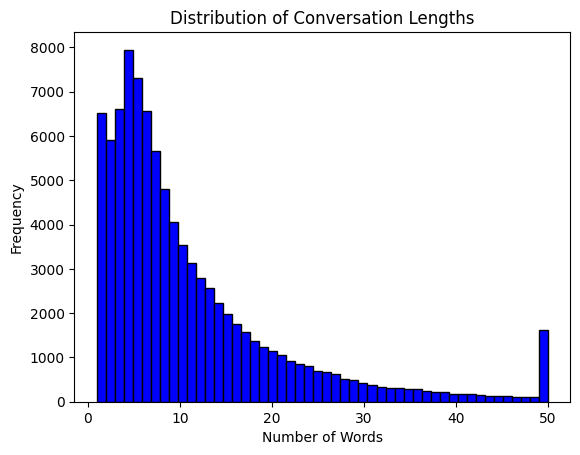

In [18]:
# Plot the histogram of conversation lengths
plt.hist(conversation_lengths, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Conversation Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

**Summary Highlights:**

* **Max conversation length:** `50 words`.
* **Mean conversation length:** `10.82 words`.
* **Median conversation length:** `7 words`.
* **90th percentile:** `24 words`.

The histogram shows a right-skewed distribution of conversation lengths, with most conversations containing fewer than `20 words`. The highest frequency occurs at around `6-8 words`, and there's a noticeable spike at `50 words`, indicating some conversations reach the maximum length.

**Recommendation:** Based on the `90th percentile`, it's recommended to use a sequence length of `24 words` for modeling purposes. This length will cover `90%` of the conversations, ensuring that the model captures the majority of the data while maintaining computational efficiency.



## **Sequence Preparation and Padding**<a id='Sequence_Preparation_and_Padding'></a>
[Contents](#Contents)

In here, we'll be defining a maximum sequence length of `24 words` (based on the `95th percentile` from the earlier analysis), to ensure that input sequences are of uniform length.

* **Padding Sequences:** The pad_sequences function pads shorter sequences with zeros to make sure all input sequences are of the same length.
* **Vocabulary Size:** The vocabulary size is calculated based on the tokenizer, which is used later for embedding layers.
* **Creating Input Sequences:** It generates input sequences and their corresponding target words by iterating over the padded sequences. This prepares the data for a language model where each input sequence will be used to predict the next word.
* **Final Padding:** Input sequences are padded again to the maximum length, and target words are converted into a NumPy array for model training.

This ensures consistency in the data, making it easier for the model to process.

In [19]:
# Define a reasonable max sequence length (based on the 95th percentile, for example)
max_sequence_length = 24  # this based on the distribution of conversation lengths

# Pad sequences to ensure uniform input length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Define your vocabulary size for embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [20]:
# Create input sequences and corresponding target words
input_sequences = []
target_words = []

for seq in padded_sequences:
    for i in range(1, len(seq)):
        input_sequences.append(seq[:i])
        target_words.append(seq[i])

# Pad input sequences to uniform length
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')

# Convert target words to numpy array
target_words = np.array(target_words)


## **Splitting Data into Training and Validation Sets**<a id='Splitting_Data_into_Training_and_Validation_Sets'></a>
[Contents](#Contents)

In here, we'll be splitting the input_sequences and target_words into training and validation datasets. Using the train_test_split function:

* **Training Set:** `80%` of the data (train_inputs, train_targets) will be used to train the model.
* **Validation Set:** `20%` of the data (val_inputs, val_targets) will be reserved to validate the model’s performance during training.

This step is crucial to evaluate how well the model generalizes to unseen data.

In [21]:
# Split input_sequences and target_words into training and validation sets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    input_sequences, target_words, test_size=0.2, random_state=42)


## **Data Generator for Efficient Batch Processing**<a id='Data_Generator_for_Efficient_Batch_Processing'></a>
[Contents](#Contents)

DataGenerator class was designed to generate batches of data for training and validation in an efficient manner, particularly useful when working with large datasets.

* **Initialization** (`__init__`): It takes the input sequences, target words, batch size, and maximum sequence length as inputs and stores them for batch generation.
* **Length** (`__len__`): This method calculates the total number of batches by dividing the total input data by the batch size.
* **Get Item** (`__getitem__`): This method retrieves a specific batch of data (input sequences and target words) by slicing the dataset based on the batch size. It returns the data in NumPy array format, which is necessary for model training.

The **train_gen** and **val_gen** objects are instances of this generator, created for the training and validation sets with a batch size of `64`, allowing the model to process data in small chunks rather than all at once. This approach helps to optimize memory usage and speed up training.

In [22]:
class DataGenerator(Sequence):
    def __init__(self, input_sequences, target_words, batch_size, max_len):
        self.input_sequences = input_sequences
        self.target_words = target_words
        self.batch_size = batch_size
        self.max_len = max_len

    def __len__(self):
        return int(np.floor(len(self.input_sequences) / self.batch_size))

    def __getitem__(self, index):
        batch_inputs = self.input_sequences[index * self.batch_size:(index + 1) * self.batch_size]
        batch_targets = self.target_words[index * self.batch_size:(index + 1) * self.batch_size]
        
        return np.array(batch_inputs), np.array(batch_targets)


In [29]:
# Batch size
batch_size = 64

# Create data generators for training and validation
train_gen = DataGenerator(train_inputs, train_targets, batch_size, max_sequence_length)
val_gen = DataGenerator(val_inputs, val_targets, batch_size, max_sequence_length)


## **LSTM Architecture**<a id='LSTM_Architecture'></a>
[Contents](#Contents)

This section outlines a sequential model designed for text sequence prediction, optimized for handling tasks like conversational agents:

* **Embedding Layer:** Transforms input words (represented as integers) into `100-dimensional dense vectors`, allowing the model to learn meaningful word embeddings. The input shape is determined by the vocabulary size and the maximum sequence length.

* **Bidirectional LSTM Layer:** A bidirectional LSTM layer with `256 units` is used to capture context from both the forward and backward directions of the input sequence. The `return_sequences=True` parameter enables stacking of LSTM layers. A dropout rate of `30%` is applied to reduce overfitting.

* **Second LSTM Layer:** This additional LSTM layer, with `128 units`, further processes the output from the first LSTM layer. Another `30% dropout` is applied for regularization.

* **Dense Layer:** A fully connected layer with `64 units` and `ReLU activation` is included to learn complex features from the LSTM outputs before making predictions.

* **Output Layer:** The output layer, using softmax activation, generates a probability distribution over the entire vocabulary, allowing the model to predict the next word in the sequence.

* **Model Compilation:** The model is compiled with the Adam optimizer and sparse categorical crossentropy as the loss function, suitable for multi-class classification tasks like next-word prediction. Accuracy is used as the evaluation metric.

* **Early Stopping:** To prevent overfitting, early stopping is applied, monitoring validation loss. If the validation loss doesn’t improve for `3 consecutive epochs`, training stops, and the best model weights are restored.

* **Training the Model:** The model is trained on the data generator (`train_gen`) for `20 epochs` with early stopping, using a validation data generator (`val_gen`) to monitor its performance.

This architecture is ideal for tasks requiring sequence prediction, such as building a conversational chatbot or other natural language processing applications.

In [30]:
# Define the model architecture
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length))

# Bidirectional LSTM layer with 256 units, return_sequences=True for stacking
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.3))  # Dropout for regularization

# Second LSTM layer with 128 units
model.add(LSTM(128))
model.add(Dropout(0.3))  # Another dropout

# Dense layer
model.add(Dense(64, activation='relu'))

# Output layer for next-word prediction (softmax to predict a probability distribution over the vocab)
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


### **LSTM Training**<a id='LSTM_Training'></a>
[Contents](#Contents)

In [31]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stopping])


Epoch 1/20
26243/26243 [==============================] - 9082s 346ms/step - loss: 3.0472 - accuracy: 0.6250 - val_loss: 2.7123 - val_accuracy: 0.6300
Epoch 2/20
26243/26243 [==============================] - 11276s 430ms/step - loss: 2.5683 - accuracy: 0.6376 - val_loss: 2.4921 - val_accuracy: 0.6454
Epoch 3/20
26243/26243 [==============================] - 10776s 411ms/step - loss: 2.3965 - accuracy: 0.6514 - val_loss: 2.3907 - val_accuracy: 0.6546
Epoch 4/20
26243/26243 [==============================] - 10517s 401ms/step - loss: 2.3116 - accuracy: 0.6591 - val_loss: 2.3482 - val_accuracy: 0.6599
Epoch 5/20
26243/26243 [==============================] - 11374s 433ms/step - loss: 2.2517 - accuracy: 0.6637 - val_loss: 2.3035 - val_accuracy: 0.6630
Epoch 6/20
26243/26243 [==============================] - 11985s 457ms/step - loss: 2.2168 - accuracy: 0.6672 - val_loss: 2.2982 - val_accuracy: 0.6659
Epoch 7/20
26243/26243 [==============================] - 12740s 485ms/step - loss: 2.195

### **LSTM LOSS & Accuracy**<a id='LSTM_LOSS_Accuracy'></a>
[Contents](#Contents)

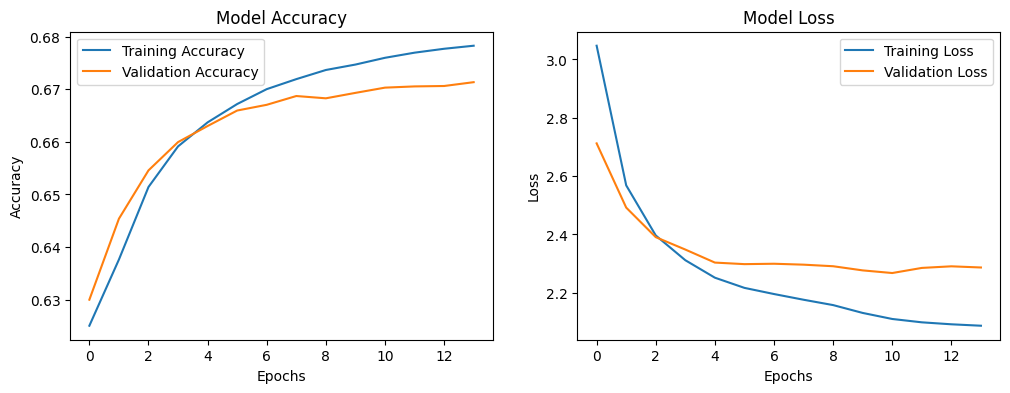

In [32]:
# Retrieve a list of accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


**Summary Highlights:**

* **Training Accuracy:**

   * The training accuracy started at 62.50% in the first epoch and steadily increased to 67.83% by epoch 14.
   * This demonstrates that the model was learning well from the data and consistently improving its predictions.

* **Validation Accuracy:**

   * The validation accuracy started at 63.00% and increased to 67.13% by epoch 14.
   * The gap between training accuracy and validation accuracy remained small, indicating that the model generalized well to unseen data and did not overfit.

* **Training Loss:**

   * The training loss started at 3.0472 and gradually decreased to 2.0870 by epoch 14.
   * This decrease in training loss indicates that the model's predictions became increasingly aligned with the true values during training.

* **Validation Loss:**

   * The validation loss started at 2.7123 and decreased to 2.2867 by epoch 14.
   * A consistent decrease in validation loss suggests that the model was improving in its ability to generalize to the validation set, although the rate of improvement slowed down after a few epochs.

* **Early Stopping:**

   * Early stopping was employed with patience=3, which means training would stop if the validation loss didn’t improve after 3 consecutive epochs. This helps avoid overfitting.
   * The model was allowed to train for 20 epochs, but training was effectively stopped by epoch 14 as the validation loss began to stabilize and no longer showed significant improvements.

* **Convergence:**

   * Both the training and validation accuracy continued to rise, while training and validation losses dropped and then began to stabilize.
   * The convergence point around epoch 14 suggests that the model reached an optimal balance between fitting the training data and generalizing to unseen data.

* **Conclusion:**
   * The model performed well, achieving 67.83% training accuracy and 67.13% validation accuracy by epoch 14.
   * The small gap between training and validation metrics indicates strong generalization capabilities.
   * The early stopping mechanism worked effectively, stopping training before overfitting could occur.
   * Total time required to train for 14 epochs is `46 hours, 20 minutes, and 43 seconds`.

## **Saving The Final LSTM Model**<a id='Saving_The_Final_LSTM_Model'></a>
[Contents](#Contents)

In [33]:
# Save the entire model to a HDF5 file
model.save('chatbot_model.h5')


C:\Users\aktha\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
# Save the model in the native Keras format
model.save('chatbot_model.keras')

In [35]:
import joblib
# Saving the tokenizer (if not done previously)
joblib.dump(tokenizer, 'tokenizer.pkl')


['tokenizer.pkl']

In [57]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_response(input_text, model, tokenizer, max_sequence_length):
    input_sequence = tokenizer.texts_to_sequences([input_text])
    input_sequence = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post')
    
    # Print input sequence for debugging
    print(f"Input sequence: {input_sequence}")

    # Predict the next word
    prediction = model.predict(input_sequence)
    
    # Find the index with the highest probability
    predicted_index = np.argmax(prediction, axis=1)[0]
    
    # Print the predicted index for debugging
    print(f"Predicted index: {predicted_index}")
    
    # Convert the predicted index back to a word
    predicted_word = tokenizer.index_word.get(predicted_index, '<unknown>')
    
    return predicted_word




In [58]:
# Check vocabulary size during training
print(f"Vocabulary size during training: {len(tokenizer.word_index)}")


Vocabulary size during training: 30110


In [59]:
def chat_with_bot_predefined(model, tokenizer, max_sequence_length, predefined_inputs):
    print("Bot: Hello! How can I help you today?")
    
    conversation_history = []
    
    for user_input in predefined_inputs:
        # Add user's input to the conversation history
        conversation_history.append(user_input)
        
        # Prepare conversation history as input for the model
        conversation_text = ' '.join(conversation_history)
        
        # Generate bot response
        bot_response = generate_response(conversation_text, model, tokenizer, max_sequence_length)
        
        # Add bot's response to conversation history
        conversation_history.append(bot_response)
        
        # Display the bot's response
        print(f"You: {user_input}")
        print(f"Bot: {bot_response}")

In [60]:
# List of predefined inputs for testing:
predefined_inputs = [
    "Hello",
    "What is the weather like today?",
    "Will it rain tomorrow?",
    "Thank you!"
]

# Start chatting with predefined inputs
chat_with_bot_predefined(model, tokenizer, max_sequence_length, predefined_inputs)


Bot: Hello! How can I help you today?
Input sequence: [[302   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]]
1/1 [==============================] - 0s 31ms/step
Predicted index: 0
You: Hello
Bot: <unknown>
Input sequence: [[ 302 2715   14   11    3 1507   38  308    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]
1/1 [==============================] - 0s 28ms/step
Predicted index: 0
You: What is the weather like today?
Bot: <unknown>
Input sequence: [[ 302 2715   14   11    3 1507   38  308 2715   64    6 1866  296    0
     0    0    0    0    0    0    0    0    0    0]]
1/1 [==============================] - 0s 26ms/step
Predicted index: 0
You: Will it rain tomorrow?
Bot: <unknown>
Input sequence: [[ 302 2715   14   11    3 1507   38  308 2715   64    6 1866  296 2715
   206    1    0    0    0    0    0    0    0    0]]
1/1 [==============================] - 0s 24ms/step
Predicted index: 2
You: Thank yo

In [61]:
def generate_top_n_predictions(input_text, model, tokenizer, max_sequence_length, top_n=5):
    # Tokenize and pad the input
    input_sequence = tokenizer.texts_to_sequences([input_text])
    input_sequence = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post')
    
    # Predict the probabilities of the next word
    predictions = model.predict(input_sequence)
    
    # Get the indices of the top N predictions
    top_n_indices = np.argsort(predictions[0])[-top_n:][::-1]
    
    # Convert indices back to words
    top_n_words = [tokenizer.index_word.get(i, '<unknown>') for i in top_n_indices]
    
    # Get the probabilities of the top N predictions
    top_n_probs = [predictions[0][i] for i in top_n_indices]
    
    return list(zip(top_n_words, top_n_probs))

In [67]:
input_text = "weather"
top_predictions = generate_top_n_predictions(input_text, model, tokenizer, max_sequence_length, top_n=5)

for word, prob in top_predictions:
    print(f"Word: {word}, Probability: {prob}")

1/1 [==============================] - 0s 35ms/step
Word: i, Probability: 0.06978916376829147
Word: s, Probability: 0.051840752363204956
Word: you, Probability: 0.036405157297849655
Word: the, Probability: 0.020859280601143837
Word: do, Probability: 0.018383480608463287
